In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import sys
import squidpy as sq

# sys.path.append("/home/icb/giovanni.palla/code/spatial-alignment/data")
# from data.simulated.generate_twod_data import generate_twod_data_partial_overlap

%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [106]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

adata = adata[adata.obs.synth_batch == "1"].copy()
sc.pp.subsample(adata, fraction=0.7)
adata

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 560 × 500
    obs: 'batch', 'idx', 'synth_batch'
    obsm: 'spatial'

In [107]:
adata.obs["batch"] = pd.Categorical(adata.obs["batch"].astype(str))

In [153]:
from moscot.problems.space import AlignmentProblem

ap = AlignmentProblem(adata).prepare(
    batch_key="batch",
    joint_attr={"attr": "X"},
    # spatial_norm=True,
)

INFO     Normalizing spatial coordinates and saving them in `adata.obsm['spatial_norm']`.                          


In [176]:
ap = ap.solve(
    alpha=0.1,
    epsilon=1e-4,
    # threshold=1e-10,
    # max_iterations=100,
    # linear_solver_kwargs={
    #     "max_iterations": 100,
    #     "threshold": 1e-10,
    # },
)

INFO     Solving problem OTProblem[stage='solved', shape=(272, 288)].                                              
WARNING  Solver did not converge                                                                                   


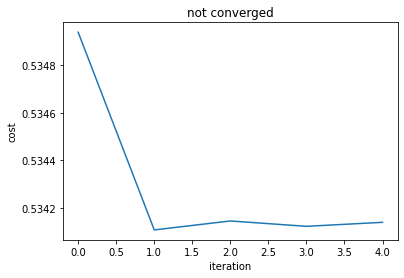

In [177]:
ap[("0", "1")].solution.plot_convergence()

In [178]:
tmap = np.array(ap[("0", "1")].solution.transport_matrix)
tmap = tmap / tmap.sum(0)

In [179]:
batch1 = adata[adata.obs.batch == "0"].copy()
batch2 = adata[adata.obs.batch == "1"].copy()
out = (batch1.obsm["spatial_norm"].T @ tmap).T

In [180]:
out = ap[("0", "1")].solution.push(batch1.obsm["spatial"], scale_by_marginals=True)

In [181]:
batch1.obsm["spatial_warp"] = batch1.obsm["spatial"]
batch2.obsm["spatial_warp"] = out
import anndata as ad

adata_temp = ad.concat([batch1, batch2])

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


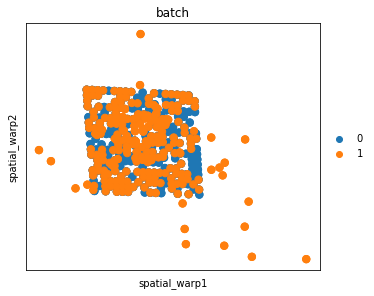

In [182]:
sq.pl.spatial_scatter(adata_temp, shape=None, color="batch", spatial_key="spatial_warp")

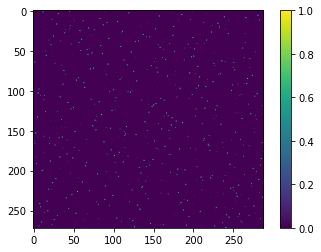

In [161]:
plt.imshow(tmap)
plt.colorbar()

In [48]:
ap.align(reference="0")

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


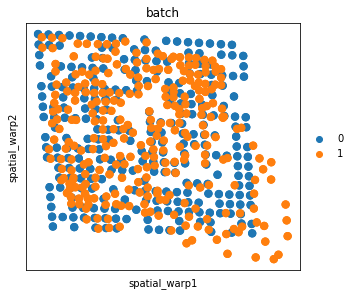

In [50]:
sq.pl.spatial_scatter(adata_temp, shape=None, color="batch", spatial_key="spatial_warp")

In [58]:
tmap.max()

0.96669436

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


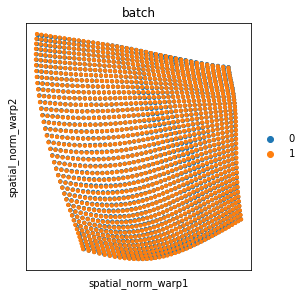

In [26]:
sq.pl.spatial_scatter(adata, shape=None, color="batch", spatial_key="spatial_norm_warp")

In [28]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()

_, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)

test_results = {}
mean_squared_error(
    ad1.obsm["spatial_norm_warp"][comm1], ad2.obsm["spatial_norm_warp"][comm2]
)

5.5208535709569563e-05

In [29]:
adata

AnnData object with n_obs × n_vars = 3200 × 500
    obs: 'batch', 'idx', 'synth_batch'
    uns: 'batch_colors'
    obsm: 'spatial', 'spatial_norm', 'spatial_norm_warp'